In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F

from pyspark.sql import SparkSession
from pyspark.sql.functions import sum,avg,format_number
from pyspark.sql.window import Window  



spark = SparkSession.builder.appName("Basics").getOrCreate()
df = spark.read.csv("healthcare-dataset-stroke-data.csv", inferSchema=True, header=True).filter(F.col('work_type')!='children')
stroke_count = df.filter(F.col("stroke") == 1).count()

# df.filter(F.col('gender')=='Female').count() /df.count() *100
# df.filter(F.col('gender')=='Female').count() / df.filter(F.col('gender')=='Male').count()


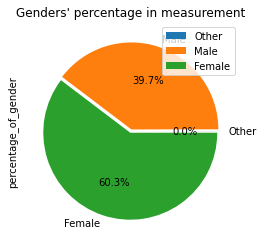

In [6]:
# -> Ποσοστό ανδρών/γυναικών με εγκεφαλικό.


df_mes = df.groupBy('gender').count().select('gender',F.col('count').alias('count_gender')).withColumn('percentage_of_gender',(F.col('count_gender') / df.count()) * 100 ).select('gender','count_gender',(format_number('percentage_of_gender',2).alias('percentage_of_gender'))).orderBy('count_gender')


pandas_df = df_mes.toPandas().astype({"gender": "string","count_gender": "int32", "percentage_of_gender": "float64"})

explode = (0.02,0.02,0.02)
labels = ['Other','Male','Female']


pandas_df.plot.pie(y="percentage_of_gender",labels=labels,autopct='%1.1f%%',explode=explode).set_title('Genders\' percentage in measurement')
plt.show()

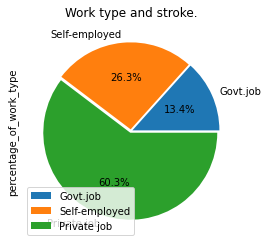

In [7]:
# -> Ποσοστό εμφάνισης εγκεφαλικού ανα τύπο εργασίας

df_work_type_stroke = (
    df.filter(df["stroke"] == 1)
    .groupBy("work_type", "stroke")
    .count()
    .select("stroke", "work_type", F.col("count").alias("work_type_count"))
    .withColumn("percentage_of_work_type", (F.col("work_type_count") / stroke_count) * 100)
    .select("work_type", (format_number("percentage_of_work_type", 2).alias("percentage_of_work_type")))
    .orderBy("work_type_count")
)



pandas_df = df_work_type_stroke.toPandas().astype({"work_type": "string", "percentage_of_work_type": "float64"})

explode = (0.02,0.02,0.02)
labels = ['Govt.job','Self-employed','Private job']

# # stroke - work_type

pandas_df.plot.pie(y="percentage_of_work_type",labels=labels,autopct='%1.1f%%',explode=explode).set_title('Work type and stroke.')
plt.show()

In [8]:
# -> ποσοστα 



# df_work_stroke_gender = (
#     df.filter(df['work_type']!= 'children')
#     .select("gender", "stroke", "work_type", F.col("count").alias("work_type_count")
#     .filter(df["stroke"] == 1)
#     .select("gender", "work_type", (format_number("percentage_of_work_type", 2).alias("percentage_of_work_type")))
#     .orderBy("work_type")
# )

w_count = df.filter(F.col('gender')=='Female').filter(F.col('stroke')==1).count()

df_work_stroke_gender_w = df.filter(F.col('gender')=='Female').filter(F.col('stroke')==1).groupBy('work_type').count().filter(F.col('work_type')!='children').withColumn('percentage',(F.col('count')/w_count)*100).select('work_type', (format_number("percentage",2).alias("percentage")))
df_work_stroke_gender_w.show()

m_count = df.filter(F.col('gender')=='Male').filter(F.col('stroke')==1).count()

df_work_stroke_gender_m = df.filter(F.col('gender')=='Male').filter(F.col('stroke')==1).groupBy('work_type').count().filter(F.col('work_type')!='children').withColumn('percentage',(F.col('count')/m_count)*100).select('work_type', (format_number("percentage",2).alias("percentage")))
df_work_stroke_gender_m.show()



+-------------+----------+
|    work_type|percentage|
+-------------+----------+
|Self-employed|     28.78|
|      Private|     54.68|
|     Govt_job|     16.55|
+-------------+----------+

+-------------+----------+
|    work_type|percentage|
+-------------+----------+
|Self-employed|     23.15|
|      Private|     67.59|
|     Govt_job|      9.26|
+-------------+----------+



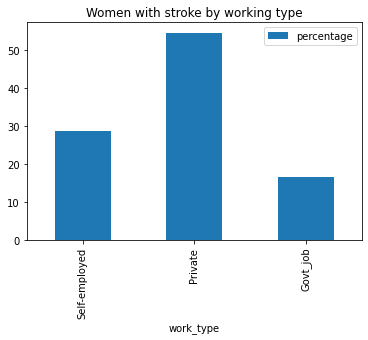

In [9]:
pandas_df = df_work_stroke_gender_w.toPandas().astype(
    {"work_type": "string", "percentage": "float64"}
)

pandas_df.plot.bar(x="work_type", y="percentage").set_title('Women with stroke by working type')
plt.show()

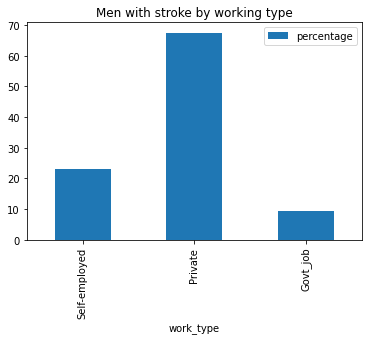

In [10]:
pandas_df = df_work_stroke_gender_m.toPandas().astype(
    {"work_type": "string", "percentage": "float64"}
)

pandas_df.plot.bar(x="work_type", y="percentage").set_title('Men with stroke by working type')
plt.show()

+-------------+-------------------------+
|    work_type|percentage_of_work_over50|
+-------------+-------------------------+
|Self-employed|                    24.70|
|      Private|                    53.85|
|     Govt_job|                    12.96|
+-------------+-------------------------+



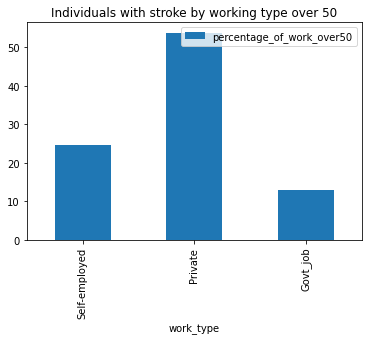

In [11]:
df_work_age = df.select('age','work_type','stroke').filter((df['stroke'] == 1) & (df['age'] > '50')).groupBy('work_type').count().withColumn('percentage_of_work_over50',(F.col('count') / stroke_count) * 100 ).select('work_type',(format_number('percentage_of_work_over50',2).alias('percentage_of_work_over50'))) 

df_work_age.show()

pandas_df = df_work_age.toPandas().astype(
    {"work_type": "string",  "percentage_of_work_over50": "float64"}
)

pandas_df.plot.bar(x="work_type", y="percentage_of_work_over50").set_title('Individuals with stroke by working type over 50')
plt.show()

+------+------------+--------------------+
|gender|count_gender|percentage_of_stroke|
+------+------------+--------------------+
|Female|          19|                7.69|
|  Male|          28|               11.34|
+------+------------+--------------------+



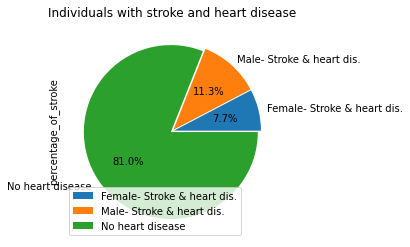

In [12]:
#people who have heart disease and stroke
df_stroke_heartdisease = df.groupBy('gender', 'stroke', 'heart_disease').count().select('gender',F.col('count').alias('count_gender')).withColumn('percentage_of_stroke',(F.col('count_gender') / stroke_count) * 100 ).filter((df['stroke'] == 1) & (df['heart_disease'] == '1')).select('gender','count_gender',(format_number('percentage_of_stroke',2).alias('percentage_of_stroke'))).orderBy('count_gender')

df_stroke_heartdisease.show()

pandas_df = df_stroke_heartdisease.toPandas().astype({"gender": "string","count_gender": "int32", "percentage_of_stroke": "float64"})

temp_df = pd.DataFrame([['No heart disease',stroke_count-19-28,100-7.63-11.24]],columns=['gender','count_gender','percentage_of_stroke'])


pandas_df = pd.concat([pandas_df,temp_df])

explode = (0.02,0.02,0.02)
labels = ['Female- Stroke & heart dis.','Male- Stroke & heart dis.','Νo heart disease']



pandas_df.plot.pie(y="percentage_of_stroke",labels=labels,autopct='%1.1f%%',explode=explode).set_title('Individuals with stroke and heart disease')
plt.show()

+------+------------+--------------------+
|gender|count_gender|percentage_of_stroke|
+------+------------+--------------------+
|  Male|          27|               10.93|
|Female|          39|               15.79|
+------+------------+--------------------+



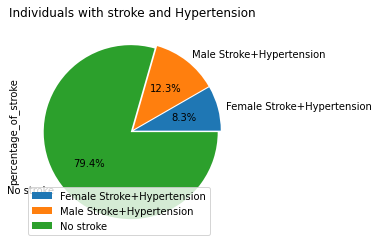

In [13]:
#people who have hypertension and stroke
df_stroke_hypertension = df.groupBy('gender', 'stroke', 'hypertension').count().select('gender',F.col('count').alias('count_gender')).withColumn('percentage_of_stroke',(F.col('count_gender') / stroke_count) * 100 ).filter((df['stroke'] == 1) & (df['hypertension'] == '1')).select('gender','count_gender',(format_number('percentage_of_stroke',2).alias('percentage_of_stroke'))).orderBy('count_gender')

df_stroke_hypertension.show()

pandas_df = df_stroke_heartdisease.toPandas().astype({"gender": "string","count_gender": "int32", "percentage_of_stroke": "float64"})

temp_df = pd.DataFrame([['No hypertension',stroke_count-27-39,100-10.84-15.66]],columns=['gender','count_gender','percentage_of_stroke'])

pandas_df = pd.concat([pandas_df,temp_df])

explode = (0.02,0.02,0.02)
labels = ['Female Stroke+Hypertension','Male Stroke+Hypertension','No stroke']



pandas_df.plot.pie(y="percentage_of_stroke",labels=labels,autopct='%1.1f%%',explode=explode).set_title('Individuals with stroke and Hypertension')
plt.show()


+------+------------+--------------------+
|gender|count_gender|percentage_of_stroke|
+------+------------+--------------------+
|Female|           7|                2.83|
|  Male|           6|                2.43|
+------+------------+--------------------+



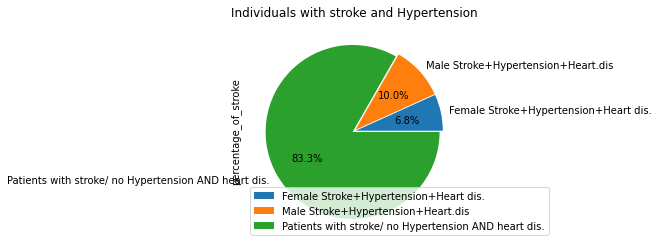

In [14]:
#people have heart disease and hypertension and stroke
df_stroke_heartd_hyperd = df.groupBy('gender', 'stroke', 'heart_disease','hypertension').count().select('gender',F.col('count').alias('count_gender')).withColumn('percentage_of_stroke',(F.col('count_gender') / stroke_count) * 100 ).filter((df['stroke'] == 1) & (df['heart_disease'] == '1') & (df['hypertension'] == '1')).select('gender','count_gender',(format_number('percentage_of_stroke',2).alias('percentage_of_stroke')))

df_stroke_heartd_hyperd.show()


pandas_df = df_stroke_heartdisease.toPandas().astype({"gender": "string","count_gender": "int32", "percentage_of_stroke": "float64"})

temp_df = pd.DataFrame([['No hypertension',stroke_count-7-6,100-2.81-2.41]],columns=['gender','count_gender','percentage_of_stroke'])

pandas_df = pd.concat([pandas_df,temp_df])

explode = (0.02,0.02,0.02)
labels = ['Female Stroke+Hypertension+Heart dis.','Male Stroke+Hypertension+Heart.dis','Patients with stroke/ no Hypertension AND heart dis.']



pandas_df.plot.pie(y='percentage_of_stroke',labels=labels,autopct='%1.1f%%',explode=explode).set_title('Individuals with stroke and Hypertension')
plt.show()

+---------------+--------------------+--------------------+
| smoking_status|count_smoking_status|percentage_of_stroke|
+---------------+--------------------+--------------------+
|         smokes|                  42|               17.00|
|        Unknown|                  45|               18.22|
|formerly smoked|                  70|               28.34|
|   never smoked|                  90|               36.44|
+---------------+--------------------+--------------------+



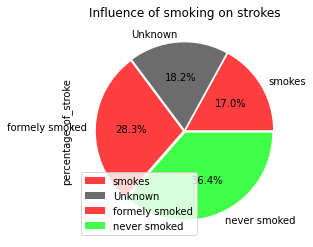

In [15]:
#influence of smoking_status on getting stroke
df_stroke_smoking= df.groupBy('smoking_status', 'stroke').count().select('smoking_status',F.col('count').alias('count_smoking_status')).withColumn('percentage_of_stroke',(F.col('count_smoking_status') / stroke_count) * 100 ).filter((df['stroke'] == 1)).select('smoking_status','count_smoking_status',(format_number('percentage_of_stroke',2).alias('percentage_of_stroke'))).orderBy('count_smoking_status')

df_stroke_smoking.show()


pandas_df = df_stroke_smoking.toPandas().astype({'smoking_status': "string",'count_smoking_status': "int32", "percentage_of_stroke": "float64"})

explode = (0.02,0.02,0.02,0.02)
labels = ['smokes','Unknown','formely smoked','never smoked']
colors = ["#FF3F3F","#6C6C6C", "#FF3F3F","#3FFF48"]



pandas_df.plot.pie(y='percentage_of_stroke',labels=labels,autopct='%1.1f%%',explode=explode,colors=colors).set_title('Influence of smoking on strokes')
plt.show()

+--------------+--------------------+--------------------+
|Residence_type|count_Residence_type|percentage_of_stroke|
+--------------+--------------------+--------------------+
|         Rural|                 113|               45.75|
|         Urban|                 134|               54.25|
+--------------+--------------------+--------------------+



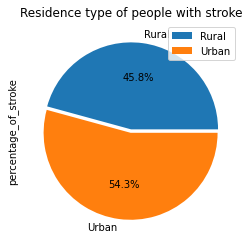

In [16]:
#influence of Residence_type on getting stroke 
df_stroke_restype= df.groupBy('Residence_type', 'stroke').count().select('Residence_type',F.col('count').alias('count_Residence_type')).withColumn('percentage_of_stroke',(F.col('count_Residence_type') / stroke_count) * 100 ).filter((df['stroke'] == 1)).select('Residence_type','count_Residence_type',(format_number('percentage_of_stroke',2).alias('percentage_of_stroke'))).orderBy('count_Residence_type')

df_stroke_restype.show()


pandas_df = df_stroke_restype.toPandas().astype({'Residence_type': "string",'count_Residence_type': "int32", "percentage_of_stroke": "float64"})

explode = (0.02,0.02)
labels = ['Rural','Urban']


pandas_df.plot.pie(y='percentage_of_stroke',labels=labels,autopct='%1.1f%%',explode=explode).set_title('Residence type of people with stroke')
plt.show()

+------------+------------------+--------------------+
|ever_married|count_ever_married|percentage_of_stroke|
+------------+------------------+--------------------+
|          No|                27|               10.93|
|         Yes|               220|               89.07|
+------------+------------------+--------------------+



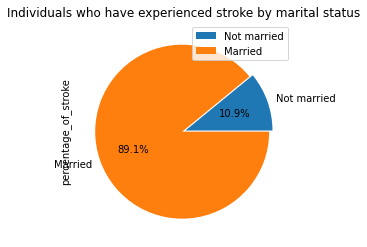

In [17]:
#influence of ever_married on getting stroke
#if married more influence on getting stroke
df_stroke_ever_married= df.groupBy('ever_married', 'stroke').count().select('ever_married',F.col('count').alias('count_ever_married')).withColumn('percentage_of_stroke',(F.col('count_ever_married') / stroke_count) * 100 ).filter((df['stroke'] == 1)).select('ever_married','count_ever_married',(format_number('percentage_of_stroke',2).alias('percentage_of_stroke'))).orderBy('count_ever_married')

df_stroke_ever_married.show()

pandas_df = df_stroke_ever_married.toPandas().astype({'ever_married': "string",'count_ever_married': "int32", "percentage_of_stroke": "float64"})

explode = (0.02,0.02)
labels = ['Not married','Married']


pandas_df.plot.pie(y='percentage_of_stroke',labels=labels,autopct='%1.1f%%',explode=explode).set_title('Individuals who have experienced stroke by marital status')
plt.show()

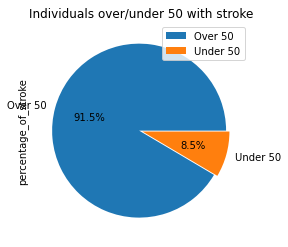

In [18]:
over_50_stroke = df.filter((df['stroke'] == 1) & (df['age'] > '50')).count()
under_50_stroke = stroke_count - over_50_stroke

pandas_df = pd.DataFrame([['over_50',over_50_stroke,over_50_stroke/stroke_count*100],['under_50',under_50_stroke,under_50_stroke/stroke_count*100]],columns=['age','age_count','percentage_of_stroke'])


explode = (0.02,0.02)
labels = ['Over 50','Under 50']


pandas_df.plot.pie(y='percentage_of_stroke',labels=labels,autopct='%1.1f%%',explode=explode).set_title('Individuals over/under 50 with stroke')
plt.show()


+------+--------+--------+----------------------+
|stroke|avg(bmi)|avg(age)|avg(avg_glucose_level)|
+------+--------+--------+----------------------+
|     1|   30.47|   68.21|                 133.1|
|     0|   30.29|   47.73|                106.49|
+------+--------+--------+----------------------+



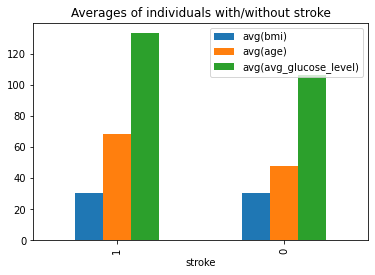

In [19]:
df_avg = df.groupBy("stroke").agg(F.round(F.mean('bmi'),scale=2), F.round(F.mean('age'),scale=2), F.round(F.mean('avg_glucose_level'),scale=2)).withColumnRenamed('round(avg(bmi), 2)','avg(bmi)').withColumnRenamed('round(avg(age), 2)','avg(age)').withColumnRenamed('round(avg(avg_glucose_level), 2)','avg(avg_glucose_level)')
df_avg.show()

pandas_df = df_avg.toPandas().astype({'stroke': "int32",'avg(bmi)': "float64", "avg(age)": "float64","avg(avg_glucose_level)":"float64"}).set_index('stroke')

pandas_df.plot.bar().set_title('Averages of individuals with/without stroke')
plt.show()
